In [1]:
%load_ext dotenv
%dotenv 

In [154]:
from pymongo import MongoClient
import os
from datasets import Dataset
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import math
from transformers import DataCollatorWithPadding

In [3]:
ID = "1308026329"
MODEL_ID = "gpt2"

In [4]:
mongo_conn = MongoClient(os.environ["MONGO_CONN"])
db = mongo_conn.twitter  # our database

subjects_collection = db["subjects_collection"]
timelines_collection = db["timelines_collection"]
peers_collection = db["peers_collection"]

# User

In [5]:
subject = subjects_collection.find_one({"id": ID})
subject

{'_id': ObjectId('63de1efed7f30964c36bb079'),
 'created_at': '2013-03-27T16:58:10.000Z',
 'description': 'Forever reading too many books at once while trying to find the perfect red lip. 👌🏼 bookstagram @starless.reader 📚',
 'entities': {'url': {'urls': [{'start': 0,
     'end': 23,
     'url': 'https://t.co/UCwYGISyGI',
     'expanded_url': 'http://www.shewritesaboutbooks.com',
     'display_url': 'shewritesaboutbooks.com'}]},
  'description': {'mentions': [{'start': 96,
     'end': 105,
     'username': 'starless'}]}},
 'id': '1308026329',
 'location': 'Perth, Australia',
 'name': 'Ｓａｍａｎｔｈａ．💜',
 'profile_image_url': 'https://pbs.twimg.com/profile_images/839815038844063744/rUZwGFvu_normal.jpg',
 'protected': False,
 'public_metrics': {'followers_count': 857,
  'following_count': 826,
  'tweet_count': 8750,
  'listed_count': 14},
 'url': 'https://t.co/UCwYGISyGI',
 'username': 'starless_reader',
 'verified': False,
 'verified_type': 'none',
 'timeline_tweets_count': 648}

# User tweets

In [77]:
user_tweets = list(timelines_collection.find({"author_id": ID, "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}))

for tweet, i in zip(user_tweets, range(10)):
    print(f"{i}.) {tweet['text']}")

0.) @PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH
1.) @PaperFury I did not ask to be called out like that 😂 https://t.co/lvHYjvAvgL
2.) The absolute best news to wake up to! 🥳🥳🥳🥳 https://t.co/SK3braPmNf
3.) 🥳🥳🥳🥳 https://t.co/yAtO3LsHMq
4.) @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
5.) A mood https://t.co/3ZEwWopeAY
6.) @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
7.) @PaperFury Still a ten 💁🏻‍♀️
8.) @PaperFury Omg 😂😂😂😂😂
9.) @shleyreads Ummmm gross?!


In [7]:
user_tweets[0]

{'created_at': '2023-01-16T13:25:49.000Z',
 'in_reply_to_user_id': '1381015116',
 'entities': {'mentions': [{'start': 0,
    'end': 10,
    'username': 'PaperFury',
    'id': '1381015116'}],
  'urls': [{'start': 56,
    'end': 79,
    'url': 'https://t.co/wRzxfTzTpH',
    'expanded_url': 'https://twitter.com/PaperFury/status/1614975937589968897',
    'display_url': 'twitter.com/PaperFury/stat…'}]},
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0,
  'impression_count': 19},
 'referenced_tweets': [{'type': 'quoted', 'id': '1614975937589968897'}],
 'possibly_sensitive': False,
 'lang': 'en',
 'author_id': '1308026329',
 'edit_history_tweet_ids': ['1614977223655829505'],
 'edit_controls': {'edits_remaining': 5,
  'is_edit_eligible': True,
  'editable_until': datetime.datetime(2023, 1, 16, 13, 55, 49)},
 'conversation_id': '1614977223655829505',
 'text': '@PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH',
 'id'

## Dataset

In [8]:
tweets_dataset = Dataset.from_list(user_tweets)

In [9]:
tweets_dataset

Dataset({
    features: ['created_at', 'in_reply_to_user_id', 'entities', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'lang', 'author_id', 'edit_history_tweet_ids', 'edit_controls', 'conversation_id', 'text', 'id', 'reply_settings', 'queried_at'],
    num_rows: 659
})

In [52]:
sample = tweets_dataset.select(range(500))

### Preprocess text

In [53]:
def remove_urls(x):
    return {"text": re.sub(r"http\S+", "", x["text"])}

def remove_extra_spaces(x):
    return {"text": " ".join(x["text"].split())}

In [54]:
updated_sample = sample.map(remove_urls).map(remove_extra_spaces)

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

In [76]:
for tweet, i in zip(updated_sample, range(10)):
    print(f"{i}.) {tweet['text']}")

0.) @PaperFury I’m taking this as a personal attack now. 😂😂
1.) @PaperFury I did not ask to be called out like that 😂
2.) The absolute best news to wake up to! 🥳🥳🥳🥳
3.) 🥳🥳🥳🥳
4.) @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
5.) A mood
6.) @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
7.) @PaperFury Still a ten 💁🏻‍♀️
8.) @PaperFury Omg 😂😂😂😂😂
9.) @shleyreads Ummmm gross?!


In [161]:
updated_sample = updated_sample.train_test_split(test_size=0.5)
updated_sample

DatasetDict({
    train: Dataset({
        features: ['created_at', 'in_reply_to_user_id', 'entities', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'lang', 'author_id', 'edit_history_tweet_ids', 'edit_controls', 'conversation_id', 'text', 'id', 'reply_settings', 'queried_at'],
        num_rows: 250
    })
    test: Dataset({
        features: ['created_at', 'in_reply_to_user_id', 'entities', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'lang', 'author_id', 'edit_history_tweet_ids', 'edit_controls', 'conversation_id', 'text', 'id', 'reply_settings', 'queried_at'],
        num_rows: 250
    })
})

### Tokenization

In [125]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [126]:
text = updated_sample[0]["text"]
text_tokenized = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(text_tokenized)
print(text)
print(text_tokenized)
print(ids)

@PaperFury I’m taking this as a personal attack now. 😂😂
['@', 'Paper', 'F', 'ury', 'ĠI', 'âĢ', 'Ļ', 'm', 'Ġtaking', 'Ġthis', 'Ġas', 'Ġa', 'Ġpersonal', 'Ġattack', 'Ġnow', '.', 'ĠðŁĺ', 'Ĥ', 'ðŁĺ', 'Ĥ']
[31, 42950, 37, 1601, 314, 447, 247, 76, 2263, 428, 355, 257, 2614, 1368, 783, 13, 30325, 224, 47249, 224]


In [127]:
decoded = tokenizer.decode(ids)
print(decoded)

@PaperFury I’m taking this as a personal attack now. 😂😂


In [128]:
tokenizer.truncation_side = "left"
tokenizer.truncation_side

'left'

In [130]:
# tokenizer.padding_side = "left"
tokenizer.padding_side

'right'

In [131]:
tokenizer.pad_token = tokenizer.eos_token

In [132]:
def tokenize_func(x):
    return tokenizer(x["text"], padding=True, return_tensors="pt")

In [162]:
tokenized_samples = updated_sample["test"].map(tokenize_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [163]:
for tweet in tokenized_samples.select(range(10)):
    print(tweet["input_ids"])
    print(tweet["attention_mask"])

[31, 380, 690, 5943, 571, 5338, 1839, 262, 4578, 996, 30, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[31, 27315, 707, 342, 259, 6024, 82, 5357, 345, 1392, 4771

In [164]:
tokenized_samples.set_format(type="torch", columns=["input_ids", "attention_mask"])

Let's find out how long our longest tweet is!

In [165]:
l_text = len(tokenized_samples[0]["input_ids"]) # all samples are equal length after padding
l_max = tokenizer.model_max_length
l_ctxt = l_max - l_text
print("Longest user input: ", l_text)
print("Max context: ", l_ctxt)

Longest user input:  96
Max context:  928


### Model

In [138]:
model = AutoModelForCausalLM.from_pretrained(MODEL_ID)

#### Perplexity

In [143]:
nlls = []

for sample in tqdm(tokenized_samples):
    input_ids = sample["input_ids"]
    attention = sample["attention_mask"]
    target_ids = torch.where(attention == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        nlls.append(neg_log_likelihood)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:32<00:00,  2.71it/s]


In [194]:
ppl = torch.exp(torch.stack(nlls).mean())
h = torch.stack(nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl)
print("Entropy: ", h)

Perplexity:  tensor(229.2714)
Entropy:  tensor(7.8409)


### Perplexity with context

Where context is 500 tokens long

#### User-conditioned

In [193]:
user_context = " ".join(updated_sample["train"]["text"])
user_context = tokenizer(user_context, truncation=True, return_tensors="pt")

In [199]:
user_nlls = []
l = 500

for sample in tqdm(tokenized_samples):
    # concatenate tensors
    input_ids = torch.cat((user_context["input_ids"][0][:l], sample["input_ids"]))
    attention_mask = torch.cat((user_context["attention_mask"][0][:l], sample["attention_mask"]))
    target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        user_nlls.append(neg_log_likelihood)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:32<00:00,  1.09s/it]


In [201]:
ppl_u = torch.exp(torch.stack(user_nlls).mean())
h_u = torch.stack(user_nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl_u)
print("Entropy: ", h_u)

Perplexity:  tensor(47.6251)
Entropy:  tensor(5.5737)


We have managed to bring down the perplexity of 229 down to 47!

#### Peer-conditioned

In [203]:
subject["id"]

peers_list = list(peers_collection.find({"mentioned_by.id": subject["id"]}, {"_id": 0}))

for peer in peers_list:
    mention = next( filter(lambda x: x["id"] == subject["id"] , peer["mentioned_by"]), None )
    print(f"username: {peer['username']} / mentioned {mention['num_mentions']} times / num tweets: {peer['timeline_tweets_count']}")

# There are 12 peers, so if we get 10 tweets each we should have more than enough...

peer_tweets = []
for peer in peers_list:
    user_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(10))
    peer_tweets.extend(user_tweets)

### Peers dataset

peers_dataset = Dataset.from_list(peer_tweets).shuffle(56)

for tweet in peers_dataset.select(range(3)):
    print(f"@{tweet['author_id']}: {tweet['text']}")

#### Preprocess

peers_dataset = peers_dataset.map(remove_urls).map(remove_extra_spaces)

username: thatidiotfrank / mentioned 79 times / num tweets: 99
username: tea_readss / mentioned 51 times / num tweets: 96
username: PaperFury / mentioned 40 times / num tweets: 94
username: thecosyreader / mentioned 14 times / num tweets: 90
username: SundayLuxe / mentioned 9 times / num tweets: 28
username: shleyreads / mentioned 7 times / num tweets: 98
username: sofiaecasanova / mentioned 7 times / num tweets: 85
username: Explore_a_thon / mentioned 6 times / num tweets: 100
username: bookswithneeks / mentioned 5 times / num tweets: 97
username: ashmcl_ / mentioned 5 times / num tweets: 94
username: udeadah / mentioned 4 times / num tweets: 83
username: DateaBook / mentioned 4 times / num tweets: 100
@365177257: Now reading "The Big Dark Sky" by @deankoontz https://t.co/hMr4NBdO9T
@389514735: now we have attack on titan final season part 3 part 1 &amp; 2 🫠 https://t.co/p7BsxZ96XS
@365177257: Now reading "Mind Walker" by @TheKateDylan https://t.co/iiSZgdr4DH


  0%|          | 0/120 [00:00<?, ?ex/s]

  0%|          | 0/120 [00:00<?, ?ex/s]

In [208]:
peer_context = " ".join(peers_dataset["text"])
peer_context = tokenizer(peer_context, truncation=True, return_tensors="pt")

peer_nlls = []
l = 500

for sample in tqdm(tokenized_samples):
    # concatenate tensors
    input_ids = torch.cat((peer_context["input_ids"][0][:l], sample["input_ids"]))
    attention_mask = torch.cat((peer_context["attention_mask"][0][:l], sample["attention_mask"]))
    target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        peer_nlls.append(neg_log_likelihood)
        
        
ppl_p = torch.exp(torch.stack(peer_nlls).mean())
h_p = torch.stack(peer_nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl_p)
print("Entropy: ", h_p)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:35<00:00,  1.10s/it]

Perplexity:  tensor(107.3776)
Entropy:  tensor(6.7466)


#### Rand user conditioned

In [209]:
rand_user_list = list(peers_collection.aggregate([ { "$sample": { "size": 15 } } ]))

for peer in rand_user_list:
    print(f"username: {peer['username']}")

rand_user_tweets = []
for peer in rand_user_list:
    user_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(10))
    rand_user_tweets.extend(user_tweets)

### Peers dataset

rand_user_dataset = Dataset.from_list(rand_user_tweets).shuffle(56)

for tweet in rand_user_dataset.select(range(3)):
    print(f"@{tweet['author_id']}: {tweet['text']}")

#### Preprocess

rand_user_dataset = rand_user_dataset.map(remove_urls).map(remove_extra_spaces)

username: LexxiSissy
username: ShanoaVanitas
username: TomBrooksComms
username: heeezye
username: thatdudechewy
username: AndrewDamien
username: WhatTheADHD
username: NeenLevi
username: AdamKinzinger
username: drunzzhq
username: ug_kitsune05
username: Anyulinfierro
username: NUJERZEYTWORK
username: Matamatically
username: Socks420
@1362198379921571843: @lgbtSnf tw // rape
-
he’s literally a rapist and ppl are still calling him the goat
@2207464167: Bruh i got PTSD 🤦🏾‍♂️ https://t.co/hZp6rDZbkw
@1362198379921571843: if ur friends ever ask you to go hiking for “fun” say no. it is not worth the pain.


  0%|          | 0/150 [00:00<?, ?ex/s]

  0%|          | 0/150 [00:00<?, ?ex/s]

In [210]:
rand_user_context = " ".join(rand_user_dataset["text"])
rand_user_context = tokenizer(rand_user_context, truncation=True, return_tensors="pt")

rand_user_nlls = []
l = 500

for sample in tqdm(tokenized_samples):
    # concatenate tensors
    input_ids = torch.cat((rand_user_context["input_ids"][0][:l], sample["input_ids"]))
    attention_mask = torch.cat((rand_user_context["attention_mask"][0][:l], sample["attention_mask"]))
    target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
        rand_user_nlls.append(neg_log_likelihood)
        
        
ppl_ru = torch.exp(torch.stack(rand_user_nlls).mean())
h_ru = torch.stack(rand_user_nlls).div(math.log(2)).mean() # nats -> bits
print("Perplexity: ", ppl_ru)
print("Entropy: ", h_ru)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:22<00:00,  1.05s/it]

Perplexity:  tensor(115.1750)
Entropy:  tensor(6.8477)


### Perplexity with increasing context

with context length = [0, 150, 300, 450, 600, 750, 900]

In [211]:
def ppl_calculator(tokenized_text, context, context_len=0):
    nlls = []
    
    for sample in tqdm(tokenized_text):
        # concatenate tensors
        input_ids = torch.cat((context["input_ids"][0][:context_len], sample["input_ids"]))
        attention_mask = torch.cat((context["attention_mask"][0][:context_len], sample["attention_mask"]))
        target_ids = torch.where(attention_mask == 0, -100, input_ids) # copy input ids, ignore padding
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
            neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
            nlls.append(neg_log_likelihood)


    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl

In [212]:
context_lengths = [0, 150, 300, 450, 600, 750, 900]

#### User-conditioned

In [213]:
# user_perplexities = []

# for cl in context_lengths:
#     ppl = ppl_calculator(tokenized_samples, user_context, context_len=cl)
#     user_perplexities.append(ppl)
#     print(f"Context length: {cl} / PPL: {ppl}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:51<00:00,  2.25it/s]


Context length: 0 / PPL: 218.21002197265625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:08<00:00,  1.94it/s]


Context length: 150 / PPL: 98.380615234375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [03:01<00:00,  1.38it/s]


Context length: 300 / PPL: 62.3774299621582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:02<00:00,  1.03it/s]


Context length: 450 / PPL: 52.02417755126953


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:24<00:00,  1.30s/it]


Context length: 600 / PPL: 35.464595794677734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:50<00:00,  1.40s/it]


Context length: 750 / PPL: 30.413591384887695


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:19<00:00,  1.52s/it]

Context length: 900 / PPL: 28.408178329467773


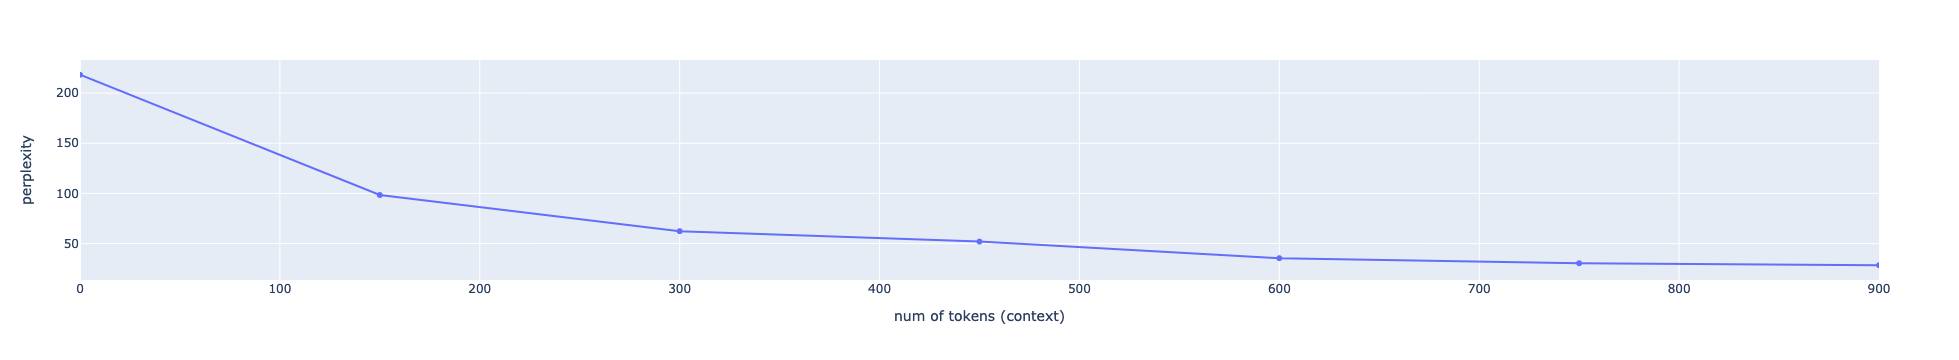

In [222]:
fig = px.line(x=context_lengths, y=user_perplexities,  markers=True)

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tokens (context)", range=(0,900))

#### Peer-conditioned

In [215]:
# peer_perplexities = []

# for cl in context_lengths:
#     ppl = ppl_calculator(tokenized_samples, peer_context, context_len=cl)
#     peer_perplexities.append(ppl)
#     print(f"Context length: {cl} / PPL: {ppl}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Context length: 0 / PPL: 218.21002197265625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:58<00:00,  2.10it/s]


Context length: 150 / PPL: 203.3916778564453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:50<00:00,  1.47it/s]


Context length: 300 / PPL: 121.16167449951172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:09<00:00,  1.00it/s]


Context length: 450 / PPL: 113.14008331298828


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:04<00:00,  1.22s/it]


Context length: 600 / PPL: 110.07367706298828


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:22<00:00,  1.53s/it]


Context length: 750 / PPL: 103.14409637451172


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:42<00:00,  1.61s/it]

Context length: 900 / PPL: 98.57676696777344


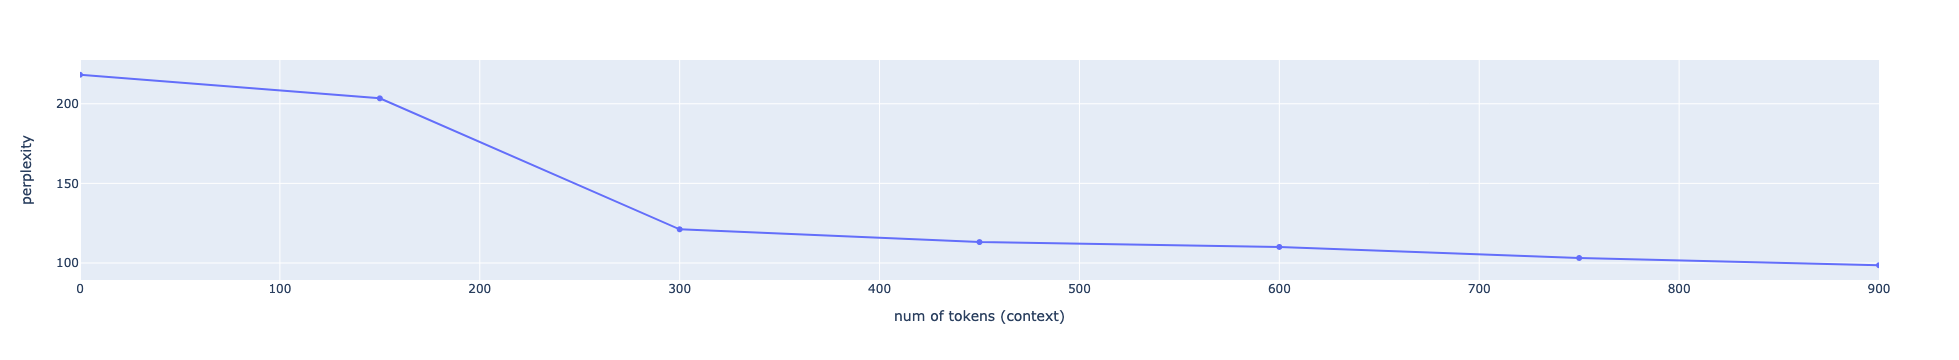

In [223]:
fig = px.line(x=context_lengths, y=peer_perplexities, markers=True)

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tokens (context)", range=(0,900))

#### Random user-conditioned

In [217]:
# rand_user_perplexities = []

# for cl in context_lengths:
#     ppl = ppl_calculator(tokenized_samples, rand_user_context, context_len=cl)
#     rand_user_perplexities.append(ppl)
#     print(f"Context length: {cl} / PPL: {ppl}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:43<00:00,  2.42it/s]


Context length: 0 / PPL: 218.21002197265625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [02:02<00:00,  2.04it/s]


Context length: 150 / PPL: 123.75933837890625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [03:03<00:00,  1.36it/s]


Context length: 300 / PPL: 130.1562042236328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:00<00:00,  1.04it/s]


Context length: 450 / PPL: 115.14969635009766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [05:40<00:00,  1.36s/it]


Context length: 600 / PPL: 111.92475891113281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:43<00:00,  1.61s/it]


Context length: 750 / PPL: 110.2685775756836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [06:34<00:00,  1.58s/it]

Context length: 900 / PPL: 114.50027465820312


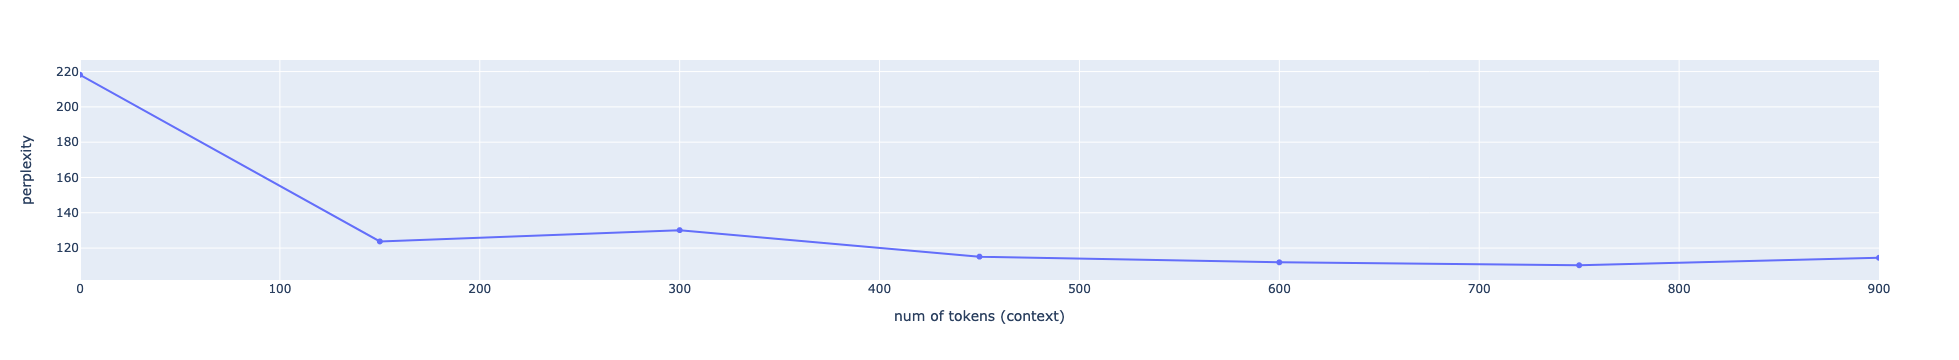

In [224]:
fig = px.line(x=context_lengths, y=rand_user_perplexities, markers=True)

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tokens (context)", range=(0,900))

In [232]:
perplexities = []

for u_ppl, cl in zip(user_perplexities, context_lengths):
    data = {}
    data["ppl"] = u_ppl
    data["context"] = "user"
    data["l_ctx"] = cl
    
    perplexities.append(data)
    
for u_ppl, cl in zip(peer_perplexities, context_lengths):
    data = {}
    data["ppl"] = u_ppl
    data["context"] = "peer"
    data["l_ctx"] = cl
    
    perplexities.append(data)
    
for u_ppl, cl in zip(rand_user_perplexities, context_lengths):
    data = {}
    data["ppl"] = u_ppl
    data["context"] = "rand_user"
    data["l_ctx"] = cl
    
    perplexities.append(data)

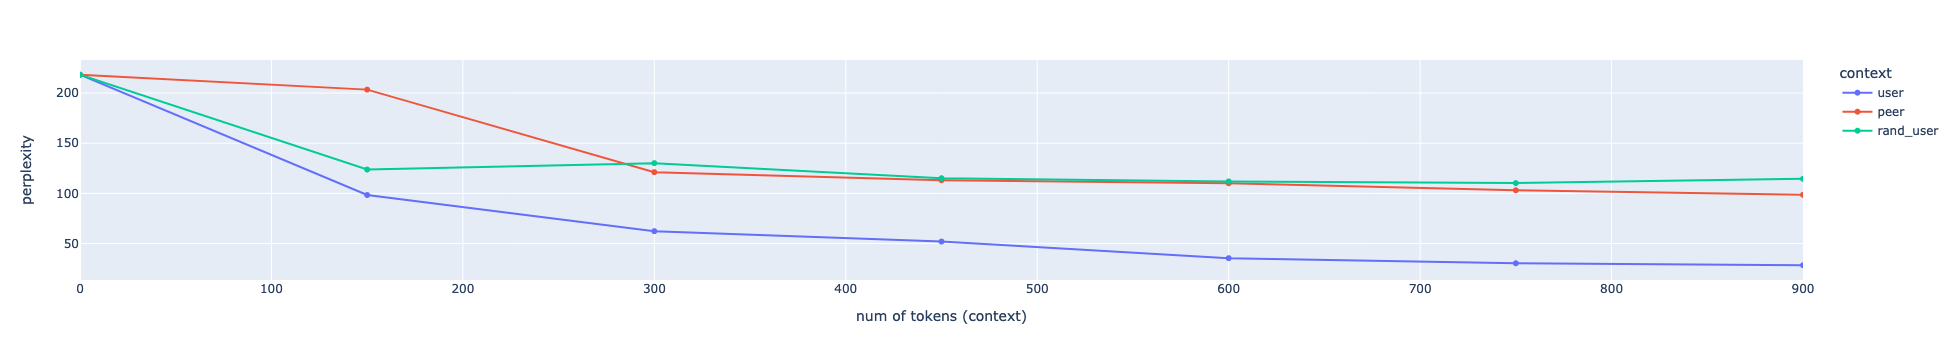

In [234]:
fig = px.line(perplexities, x="l_ctx", y="ppl", color="context", markers=True)
fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tokens (context)", range=(0,900))

Unfortunately PPL(user|peer data) is roughly the same as PPL(user|rand user data)...